## Word Embedding

### GOAL: use 3 chars to predict the following one

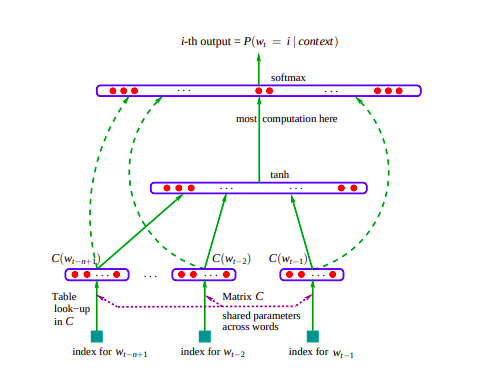

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [4]:
# 1. create the dataset
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
# char to integer mapping
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0 

# integer to char mapping
itos = {i:s for s,i in stoi.items()}

In [6]:
BLOCK_SIZE = 3
def build_dataset(words):
    xs = []; ys = []
    for word in words:
        contxt = [0]*BLOCK_SIZE
        for ch in word+".":
            i = stoi[ch]
            xs.append(contxt)
            ys.append(i)
            contxt = contxt[1:] + [i]
    xs = torch.tensor(xs); ys = torch.tensor(ys)
    print(xs.shape, ys.shape)
    return xs, ys
        

### build the dataset

In [34]:
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])[:10]
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

Xtr = Xtr[:100]; Ytr = Ytr[:100]
Xtr.shape

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


torch.Size([100, 3])

### what's next
inputs to neural networks cannot be words, so we use what's called `embeddings` which transforms words into numbers  
first layer is just the embeddings  
the input is the raw `x` (string of 3 letters) -> output is the 2 numbers for each letter -> total of 6


what to expect when we do `X @ C`?
> x is for example `27*3` for each row the output is `3*2` ---> total of `27*6`  but then we wanna separate each 2 outputs such that output is 

In [40]:
g = torch.Generator().manual_seed(2147483647) 


N_EMBED = 2
# h = F.one_hot(xs, num_classes=27).to(torch.float32) @ C equivalent to C[x]
C = torch.randn((27, N_EMBED), generator=g, requires_grad=True)
embeddings = C[Xtr]
embeddings.shape # for each letter in the 32*3 matrix -> the output is 1*2

HIDDEN_LAYER_SIZE = 100
W1 = torch.empty((BLOCK_SIZE*N_EMBED, HIDDEN_LAYER_SIZE), requires_grad=True)
b1 = torch.randn(HIDDEN_LAYER_SIZE, generator=g, requires_grad=True)

# preventing tanh result from saturating at 1 of -1 (gradient will vanish)
torch.nn.init.kaiming_normal_(W1, nonlinearity='tanh')  # Kaiming normal for tanh
b1.data.mul_(0.01)

h =  torch.tanh(embeddings.view((-1, 6)) @ W1 + b1)
# 32 6 @ 6 100 = 32 * 100
# 32 100
# 1  100b

W2 = torch.randn((HIDDEN_LAYER_SIZE, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

# initially the loss should be almost -log(1/27) aka logits are following uniform distr. (initially all of the are zeroes (equal))
W2.data.mul_(0.01)
b2.data.mul_(0.0)

logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)

print(f"desired initial loss = {-torch.log(torch.tensor(1/27.0))} vs current loss: {loss.item()}")

desired initial loss = 3.295836925506592 vs current loss: 3.294808864593506


In [41]:
# NOTE: You must set requires_grad=True before you compute logits and loss.
params = [C, W1, b1, W2, b2]
    
sum(param.nelement() for param in params)


3481

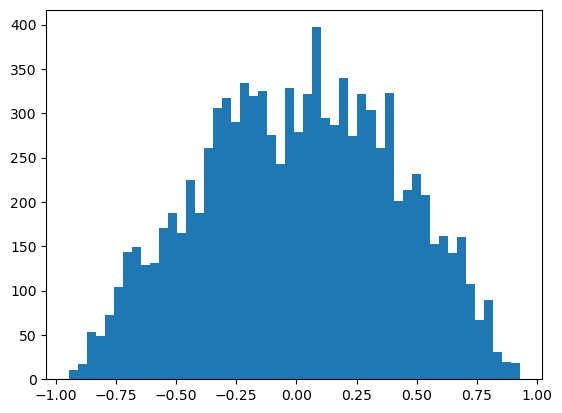

In [42]:
plt.hist(h.view(-1).tolist(), bins=50);

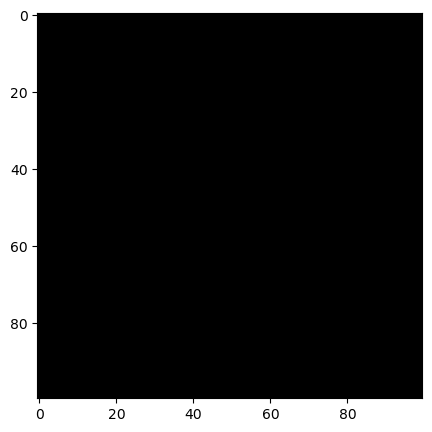

In [39]:
plt.figure(figsize=(10, 5))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest"); # returns white if True
# if a column is totally white then the neuron is dead (no single training example activates it)  

In [43]:
lr = 0.1
# backward pass:
for param in params:
    param.grad = None
loss.backward()

for param in params:
    param.data -= lr * param.grad

In [24]:
loss.item()

3.297165870666504

### what's the appropriate value of the `learning rate`:


```py
# test for different values of learning rate (lr) to find a stable and effective value
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

losses = [];

# putting everything together:
for i in range(100):
    # forward pass:
    embeddings = C[Xtr]
    h =  torch.tanh(embeddings.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr)
    losses.append(loss.item())
    
    # backward pass:
    for param in params:
        param.grad = None
    loss.backward()

    for param in params:
        param.data -= lrs[i] * param.grad
    
plt.plot(lre, losses) # choose the value at the ()
    
# ---- How to choose a good learning rate? ----
# Look for the lowest point on the curve before the loss spikes or becomes unstable.
# A good learning rate is where the loss is low and the curve is still smooth (not exploding).
# Pick a value just before the loss starts to increase or oscillate wildly.
```

In [25]:
# putting everything together:
for i in range(100):
    # forward pass:
    embeddings = C[Xtr]
    h =  torch.tanh(embeddings.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr)
    
    # backward pass:
    for param in params:
        param.grad = None
    loss.backward()

    for param in params:
        param.data -= 0.1 * param.grad
    

print(f"loss (training set): {loss.item()}")

loss (training set): 2.861135482788086


In [ ]:
logits.max(1)

### Testing on the validation set

In [ ]:
# Evaluate the loss in the dev set
embeddings = C[Xdev]
h =  torch.tanh(embeddings.view((-1, 6)) @ W1 + b1)

logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f"loss (validation set): {loss.item()}")

### sampling from the model

In [ ]:
for i in range(20):
    contxt = [0]*BLOCK_SIZE
    outs = []
    while True:
        embedding = C[torch.tensor([contxt])]
        h =  torch.tanh(embedding.view((-1, 6)) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, 1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        outs.append(ix)
        contxt = contxt[1:] + [ix]
        if ix == 0: break
    print("".join(itos[i] for i in outs))
    
# these names sound too weird :(